### Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Imported Powerpoints/car-safety'    #project folder directory

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd 'gdrive/My Drive/Imported Powerpoints/car-safety'

/content/gdrive/My Drive/Imported Powerpoints/car-safety


In [0]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import json
import math
import requests
import numpy as np

pd.options.display.max_columns = None

### Getting data

#### Reading Car rating from API

In [0]:
def get_vehicle_id(year, make, model):
    response = requests.get('https://webapi.nhtsa.gov/api/SafetyRatings/modelyear/%s/make/%s/model/%s?format=json' % (year, make, model))
    if response.status_code == 200:
        json_response = response.json()
        print(json_response['Message'])
        if int(json_response['Count']) > 0:
            return json_response['Results'][0]['VehicleId']
    else:
        print ('API request failed.', response.status_code)
    return '-1'

In [5]:
vehicle_id = get_vehicle_id('1990', 'audi', '100')
print(vehicle_id)
cur_car_rating = requests.get('https://webapi.nhtsa.gov/api/SafetyRatings/VehicleId/%s?format=json' % vehicle_id)
json_car = cur_car_rating.json()
rating = json_car['Results'][0]['OverallRating']
print(rating)

Results returned successfully
2872
Not Rated


#### Reading CSV files

In [6]:
df_tests = pd.read_csv('data/test.psv', sep = '|', encoding = 'unicode_escape')
df_vehicles = pd.read_csv('data/veh.psv', sep = '|', encoding = 'unicode_escape')
df_uk_accidents = pd.read_csv('data/uk_accidents.csv', encoding = 'unicode_escape')
df_uk_vehicles = pd.read_csv('data/uk_vehicles.csv', encoding = 'unicode_escape')
df_uk_casualties = pd.read_csv('data/uk_casualties.csv', encoding = 'unicode_escape')
df_uk_makes = pd.read_csv('data/Vehicle_Information.csv', usecols = [0, 10, 11, 19], encoding = 'unicode_escape')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
len(df_uk_vehicles)

3753696

### Preprocessing

In [0]:
# Appending makes and models to the UK vehicles DF
if 'Vehicle_Make' not in df_uk_vehicles:
    df_uk_vehicles = pd.merge(df_uk_vehicles, df_uk_makes, on = ['Accident_Index', 'Vehicle_Reference'], how='left')
    
# Rename vehicle make, model to follow the same convention
df_uk_vehicles.rename(columns={'make': 'Vehicle_Make', 'model': 'Vehicle_Model'}, inplace = True)


# Mapping numeric values to corresponding text
df_uk_vehicles_map = {
    'Sex_of_Driver': {-1: np.nan, 3: np.nan, 2: 'Female', 1: 'Male'},
    'Age_Band_of_Driver': {-1: np.nan, 1: '0-5', 2: '6-10', 3: '11-15', 4: '16-20', 5: '21-25', 6: '26-35', 7: '36-45', 8: '46-55', 9: '56-65', 10: '66-75', 11: 'Over 75'}, 
    'Vehicle_Make': {'MISSING': np.nan},
    'Vehicle_Model': {'MISSING': np.nan},
    'Age_of_Vehicle': {-1: np.nan},
    '1st_Point_of_Impact': {-1: np.nan, 1: 'Front', 2: 'Back', 3: 'Offside', 4: 'Nearside'},
    'Vehicle_Manoeuvre': {-1: np.nan, 1: 'Reversing', 2: 'Parked', 3: 'Waiting to go - held up', 4: 'Slowing or stopping', 5: 'Moving off', 6: 'U-turn', 7: 'Turning left', 8: 'Waiting to turn left', 9: 'Turning right', 10: 'Waiting to turn right', 11: 'Changing lane to left', 12: 'Changing lane to right', 13: 'Overtaking moving vehicle – offside', 14: 'Overtaking static vehicle - offside', 15: 'Overtaking - nearside', 16: 'Going ahead left-hand bend', 17: 'Going ahead right-hand bend', 18: 'Going ahead other'},
    'Vehicle_Type': {-1: np.nan, 90: np.nan, 1: 'Pedal cycle', 2: 'Motorcycle <=50cc', 3: 'Motorcycle <=125cc', 4: 'Motorcycle 125cc-500cc', 5: 'Motorcycle >500cc', 8: 'Taxi/Private hire car', 9: 'Car', 10: 'Minibus (8-16 seats)', 11: 'Bus (>=17 seats)', 16: 'Ridden horse', 17: 'Agricultural vehicle', 18: 'Tram', 19: 'Van <=3.5 t.', 20: 'Goods 3.5t.-7.5t', 21: 'Goods >=7.5 t.', 22: 'Mobility scooter', 23: 'Electric motorcycle', 97: 'Motorcycle - unknown cc', 98: 'Goods vehicle - unknown weight'}
}
df_uk_accidents_map = {
    'Accident_Severity': {-1: np.nan, 1: 'Fatal', 2: 'Serious', 3: 'Slight'},
    'Weather_Conditions': {-1: np.nan, 8: np.nan, 9: np.nan, 1: 'Fine no high winds', 2: 'Raining no high winds', 3: 'Snowing no high winds', 4: 'Fine + high winds', 5: 'Raining + high winds', 6: 'Snowing + high winds', 7: 'Fog or mist'},
    'Light_Conditions': {-1: np.nan, 1: 'Daylight', 4: 'Darkness - lights lit', 5: 'Darkness - lights unlit', 6: 'Darkness - no lighting', 7: 'Darkness - lighting unknown'}
}
df_uk_casualties_map = {
    'Casualty_Severity': {-1: np.nan, 1: 'Fatal', 2: 'Serious', 3: 'Slight'},
    'Sex_of_Casualty': {-1: np.nan, 3: np.nan, 2: 'Female', 1: 'Male'},
    'Casualty_Class': {-1: np.nan, 1: 'Driver or rider', 2: 'Passenger', 3: 'Pedestrian'}
}

for key in df_uk_vehicles_map:
    for old_value in df_uk_vehicles_map[key]:
        df_uk_vehicles[key] = df_uk_vehicles[key].replace(old_value, df_uk_vehicles_map[key][old_value])
for key in df_uk_accidents_map:
    for old_value in df_uk_accidents_map[key]:
        df_uk_accidents[key] = df_uk_accidents[key].replace(old_value, df_uk_accidents_map[key][old_value])
for key in df_uk_casualties_map:
    for old_value in df_uk_casualties_map[key]:
        df_uk_casualties[key] = df_uk_casualties[key].replace(old_value, df_uk_casualties_map[key][old_value])

# Converting UK Accident_Index to string
df_uk_vehicles.Accident_Index = df_uk_vehicles.Accident_Index.astype(str)
df_uk_accidents.Accident_Index = df_uk_accidents.Accident_Index.astype(str)
df_uk_casualties.Accident_Index = df_uk_casualties.Accident_Index.astype(str)

# Converting UK number columns to floats
df_uk_vehicles.Age_of_Vehicle = df_uk_vehicles.Age_of_Vehicle.astype(float)

# Calculating vehicle year from age_of_vehicle and accident date
if 'Vehicle_Year' not in df_uk_vehicles:
    df_uk_vehicles = pd.merge(df_uk_vehicles, df_uk_accidents[['Accident_Index', 'Date']], on = ['Accident_Index'], how='left')
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles.Date.str.extract(r'([0-9][0-9][0-9][0-9])', expand=True)
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles['Vehicle_Year'].astype(float)
    df_uk_vehicles['Vehicle_Year'] = df_uk_vehicles['Vehicle_Year'] - df_uk_vehicles.Age_of_Vehicle  
    
# Dropping unneccessary columns
df_uk_vehicles.drop(columns = ['Date', 'Towing_and_Articulation', 'Was_Vehicle_Left_Hand_Drive?', 'Driver_IMD_Decile', 'Vehicle_IMD_Decile'], inplace = True, errors = 'ignore')
df_uk_accidents.drop(columns = ['Local_Authority_(District)', 'Local_Authority_(Highway)', 'LSOA_of_Accident_Location'], inplace = True, errors = 'ignore')
df_uk_casualties.drop(columns = ['Casualty_Home_Area_Type', 'Casualty_IMD_Decile'], inplace = True, errors = 'ignore')

In [9]:
len(df_uk_vehicles.Accident_Index.unique())

2047256

#### Removing accidents not involving cars or vans

In [0]:
car_accident_indicies = df_uk_vehicles[(df_uk_vehicles.Vehicle_Type == 'Car') | (df_uk_vehicles.Vehicle_Type == 'Van <=3.5 t.')].Accident_Index.unique()
df_uk_vehicles = df_uk_vehicles[df_uk_vehicles.Accident_Index.isin(car_accident_indicies)]
df_uk_accidents = df_uk_accidents[df_uk_accidents.Accident_Index.isin(car_accident_indicies)]
df_uk_casualties = df_uk_casualties[df_uk_casualties.Accident_Index.isin(car_accident_indicies)]

In [11]:
df_vehicles_processed = df_uk_vehicles[df_uk_vehicles.Vehicle_Make.notnull() 
                              & df_uk_vehicles.Vehicle_Model.notnull()
                              & df_uk_vehicles.Vehicle_Year.notnull()]
len(df_vehicles_processed)                              

1332830

#### Matching uk vehicle model names to NCAP model names

In [0]:
unique_uk_makes = df_uk_vehicles.Vehicle_Make.astype(str).unique()
unique_ncap_makes = df_vehicles[' MAKED'].astype(str).unique()
unique_uk_makes.sort()
unique_ncap_makes.sort()

df_vehicles_processed = df_uk_vehicles[df_uk_vehicles.Vehicle_Make.notnull() 
                              & df_uk_vehicles.Vehicle_Model.notnull()
                              & df_uk_vehicles.Vehicle_Year.notnull()]
df_vehicles_processed = df_vehicles_processed[(df_vehicles_processed.Vehicle_Year >= 1990) & ((df_vehicles_processed.Vehicle_Type == 'Car')|(df_vehicles_processed.Vehicle_Type == 'Van <=3.5 t.'))]
df_years_grouped = df_vehicles_processed.groupby('Vehicle_Year')

In [13]:
len(df_vehicles_processed)

1234772

In [0]:
df_uk_ncap_match = pd.DataFrame()

for year, df_year_group in df_years_grouped:    
    url_call = 'https://webapi.nhtsa.gov/api/SafetyRatings/modelyear/%s?format=json' % (str(int(year)))
    response = requests.get(url_call)
    if response.status_code == 200:
        results = response.json()['Results']
    else:
        print (response)
    
    available_year_makes = []
    for entry in results:
        available_year_makes.append(entry['Make'])
        #print (entry['Make'])
    
    df_cur_makes = df_year_group.copy(deep = False)
    df_cur_makes = df_cur_makes[df_cur_makes.Vehicle_Make.isin(available_year_makes)]
    df_makes_grouped = df_cur_makes.groupby('Vehicle_Make')
    
    for make, df_make_group in df_makes_grouped:
        url_call = 'https://webapi.nhtsa.gov/api/SafetyRatings/modelyear/%s/make/%s?format=json' % (str(int(year)), make)
        response = requests.get(url_call)
        if response.status_code == 200:
            results = response.json()['Results']
        else:
            print (response)
            
        available_models = []
        for entry in results:
            available_models.append(entry['Model'])
            
        df_cur_models = df_make_group.copy(deep = False)
        df_models_grouped = df_cur_models.groupby('Vehicle_Model')
        
        for uk_model, df_model_group in df_models_grouped:
            for ncap_model in available_models:
                if ncap_model in uk_model:
                    df_match = df_model_group[((df_model_group.Vehicle_Model == uk_model) &
                                                                 (df_model_group.Vehicle_Make == make) &
                                                                 (df_model_group.Vehicle_Year.astype(int) == int(year)))]
                    df_match.Vehicle_Model = df_match.Vehicle_Model.replace(uk_model, ncap_model)
                    if (len(df_uk_ncap_match) == 0):
                        df_uk_ncap_match = df_match
                    else:
                        df_uk_ncap_match = df_uk_ncap_match.append(df_match)
    
#df_uk_ncap_match.to_csv('matched_vehicles.csv')

In [0]:
df_uk_ncap_match = pd.read_csv('matched_vehicles.csv')

In [15]:
df_uk_ncap_match.head()

,Accident_Index,Vehicle_Reference,Vehicle_Type,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_Home_Area_Type,Vehicle_Make,Vehicle_Model,Vehicle_Year
0,200540B016730,3,Car,Slowing or stopping,0,1,1,0,0,0,Back,2,Female,46,46-55,1994,1,15,2,AUDI,100,1990
1,2007440586334,2,Car,Going ahead left-hand bend,0,0,0,0,0,0,Front,15,Female,39,36-45,2309,1,17,1,AUDI,100,1990
2,2014450015038,1,Car,Going ahead other,0,0,0,0,0,0,Front,6,Male,62,56-65,2494,1,24,1,BMW,325I,1990
3,2013130330185,1,Car,Going ahead other,0,8,1,0,0,0,Front,6,Male,26,26-35,2494,1,23,1,BMW,325I,1990
4,2013450007167,2,Car,Going ahead other,0,6,0,0,0,0,Offside,6,Male,-1,NaN,2494,1,23,1,BMW,325I,1990


In [16]:
df_uk_ncap = df_uk_ncap_match.drop_duplicates(subset = ['Vehicle_Model','Vehicle_Make','Vehicle_Year'])
print(len(df_uk_ncap))

1589


Getting overall rating of matched vehicles from NCAP

In [0]:
df_uk_ncap = df_uk_ncap_match.drop_duplicates(subset = ['Vehicle_Model','Vehicle_Make','Vehicle_Year'])
df_uk_ncap['OverallRating'] = -1
length = len(df_uk_ncap)
for i in range(length):
  year = df_uk_ncap.loc[df_uk_ncap.index[i],'Vehicle_Year']
  make = df_uk_ncap.loc[df_uk_ncap.index[i],'Vehicle_Make']
  model = df_uk_ncap.loc[df_uk_ncap.index[i],'Vehicle_Model']
  url_call = 'https://webapi.nhtsa.gov/api/SafetyRatings/modelyear/%s/make/%s/model/%s?format=json' % (str(int(year)), make, model)
  response = requests.get(url_call)
  if(i==1055):
    print('said JSON decode error')
  elif response.status_code == 200:
          print(i)
          json_response = response.json()
          if int(json_response['Count']) > 0:
            vehicle_id = json_response['Results'][0]['VehicleId'] 
            rating_response = requests.get('https://webapi.nhtsa.gov/api/SafetyRatings/VehicleId/%s?format=json' % vehicle_id)
            if rating_response.status_code == 200:
                json_rating_response = rating_response.json()
                if int(json_response['Count']) > 0:
                  rating = json_rating_response['Results'][0]['OverallRating'] 
                  df_uk_ncap['OverallRating'].iloc[i] = rating                                  
            else:
                print ('API request failed.', response.status_code)      
  else:
        print ('API request failed.', response.status_code)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


For i = 1055, Json response is positive, but no results present(getting JSON decode error).  So Manually retrieved

In [0]:
print(df_uk_ncap.loc[df_uk_ncap.index[1055],'Vehicle_Year'])
print(df_uk_ncap.loc[df_uk_ncap.index[1055],'Vehicle_Make'])
print(df_uk_ncap.loc[df_uk_ncap.index[1055],'Vehicle_Model'])

2011
BMW
528I 


In [0]:
df_uk_ncap['OverallRating'].iloc[1055] = 'Not Rated'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
len(df_uk_ncap[df_uk_ncap.OverallRating != 'Not Rated'])

199

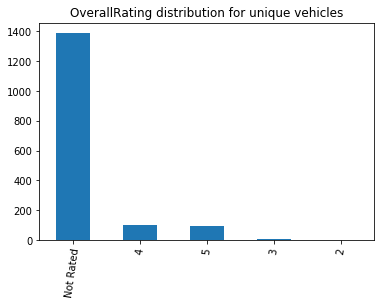

In [22]:
df_uk_ncap['OverallRating'].value_counts().head().plot(kind='bar', title = 'OverallRating distribution for unique vehicles', rot=82)

In [0]:
df_uk_ncap_rating = pd.merge(df_uk_ncap_match,df_uk_ncap[['Vehicle_Make','Vehicle_Model','Vehicle_Year','OverallRating']],on=['Vehicle_Make','Vehicle_Model','Vehicle_Year'],how='left')

Getting information of cars which are rated

In [0]:
df_uk_ncap_rating.to_csv('Matched_with_OverallRating.csv')

In [0]:
df_uk_ncap_rating =pd.read_csv('Matched_with_OverallRating.csv')

In [18]:
df_uk_ncap_rating['OverallRating'].unique()

array(['Not Rated', '4', '5', '3', '2'], dtype=object)

Involving accidents only for Overall rated vehicles and Casualty Severity  is fatal or serious 

In [41]:
rated_accident_indices = df_uk_ncap_rating[df_uk_ncap_rating.OverallRating != 'Not Rated' ].Accident_Index.unique()
df_uk_ncap_rating_copy = df_uk_ncap_rating[df_uk_ncap_rating.Accident_Index.isin(rated_accident_indices)]
df_uk_casualties_copy = df_uk_casualties[df_uk_casualties.Accident_Index.isin(rated_accident_indices)]
df_uk_casualties_copy = df_uk_casualties_copy[df_uk_casualties.Casualty_Severity != 'Slight']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [42]:
len(df_uk_ncap_rating_copy)

20098

In [43]:
len(df_uk_casualties_copy)

2357

In [40]:
df_uk_casualties_copy.Casualty_Severity.unique()

array(['Serious', 'Slight', 'Fatal'], dtype=object)

In [44]:
df_uk_casualties_copy.tail(10)

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type
2754337,201497UA03804,1,2,Passenger,Male,18,4,Fatal,0,0,1,0,0,9
2754338,201497UA03804,1,4,Driver or rider,Male,18,4,Serious,0,0,0,0,0,9
2754339,201497UA03804,2,1,Passenger,Female,52,8,Fatal,0,0,1,0,0,9
2754340,201497UA03804,2,3,Driver or rider,Male,64,9,Serious,0,0,0,0,0,9
2754607,201497UC40406,1,1,Driver or rider,Female,55,8,Serious,0,0,0,0,0,9
2754706,201497UD01409,1,1,Passenger,Female,78,11,Fatal,0,0,1,0,0,9
2754707,201497UD01409,1,5,Driver or rider,Male,78,11,Serious,0,0,0,0,0,9
2754708,201497UD01409,2,2,Passenger,Female,7,2,Serious,0,0,2,0,0,9
2754709,201497UD01409,2,3,Passenger,Female,48,8,Serious,0,0,1,0,0,9
2754710,201497UD01409,2,4,Driver or rider,Male,46,8,Serious,0,0,0,0,0,9


Getting num of casualties in a particular accident and particular vehicle reference

In [0]:
Casualties_info = pd.DataFrame()
df_uk_casualties_copy['No_of_casualties_in_veh_ref'] = -1
df_uk_casualties_acc_group = df_uk_casualties_copy.groupby('Accident_Index')
for acc_index, acc_index_group in df_uk_casualties_acc_group:
  df_acc_group = acc_index_group.copy(deep = False)
  df_veh_ref_group = df_acc_group.groupby('Vehicle_Reference')
  for veh_ref, veh_ref_group in df_veh_ref_group:
    deaths = len(veh_ref_group)
    copying = veh_ref_group[(veh_ref_group.Accident_Index == acc_index) & (veh_ref_group.Vehicle_Reference == veh_ref)]
    copying.No_of_casualties_in_veh_ref = copying.No_of_casualties_in_veh_ref.replace(-1, deaths)
    if (len(Casualties_info) == 0):
      Casualties_info = copying
    else:
      Casualties_info = Casualties_info.append(copying)

In [48]:
Casualties_info.head(10)

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,No_of_casualties_in_veh_ref
2183912,201201CW11524,1,1,Pedestrian,Female,19,4,Serious,1,1,0,0,2,0,1
2184508,201201EK40324,1,1,Pedestrian,Male,22,5,Serious,4,1,0,0,2,0,1
2184841,201201EK40651,1,1,Driver or rider,Male,39,7,Serious,0,0,0,0,0,1,1
2187098,201201GD10742,1,1,Pedestrian,Male,27,6,Serious,5,1,0,0,2,0,1
2191323,201201KG70023,1,1,Driver or rider,Female,19,4,Serious,0,0,0,0,0,9,1
2200818,201201TB00567,1,1,Pedestrian,Male,12,3,Serious,5,2,0,0,2,0,1
2201065,201201TB00814,1,1,Pedestrian,Male,23,5,Serious,5,1,0,0,2,0,1
2201530,201201TD00031,1,1,Pedestrian,Male,26,6,Fatal,4,1,0,0,2,0,1
2204250,201201WW50400,2,1,Driver or rider,Male,25,5,Serious,0,0,0,0,0,3,1
2205047,201201XD80096,1,1,Pedestrian,Female,50,8,Serious,6,9,0,0,2,0,1


In [0]:
df_uk_ncap_rating_compare = pd.merge(df_uk_ncap_rating_copy,Casualties_info[['Accident_Index','Vehicle_Reference','No_of_casualties_in_veh_ref']],on=['Accident_Index','Vehicle_Reference'],how='left')
df_to_compare = df_uk_ncap_rating_compare[df_uk_ncap_rating_compare.OverallRating != 'Not Rated']
df_to_compare = df_to_compare.dropna(subset = ['No_of_casualties_in_veh_ref'])
df_rate_casualty_compare = df_to_compare[['Accident_Index','Vehicle_Reference','No_of_casualties_in_veh_ref','OverallRating']]


In [47]:
df_rate_casualty_compare.tail(10)

,Accident_Index,Vehicle_Reference,No_of_casualties_in_veh_ref,OverallRating
19862,2016950002844,1,1.0,5
19918,2016420100598,2,1.0,4
19973,2016450078675,3,2.0,5
19974,2016450078675,3,2.0,5
19980,2016521602756,1,2.0,5
19981,2016521602756,1,2.0,5
20021,201604WB16137,1,1.0,5
20063,2014440176525,2,1.0,2
20083,201601KF60036,1,1.0,2
20138,2016621600619,1,1.0,4


Same make,model,year has multiple num of casualties - taking average of casualties

In [0]:
df_uk_ncap_final = df_rate_casualty_compare.drop_duplicates(subset = ['Accident_Index','Vehicle_Reference'])

In [54]:
df_uk_ncap_final.head(10)

,Accident_Index,Vehicle_Reference,No_of_casualties_in_veh_ref,OverallRating
2039,2013350315713,1,1.0,4
2046,2013440483303,2,1.0,4
2092,201411SC18844,1,2.0,4
2095,2016420047522,1,3.0,4
2114,201697AB02906,1,1.0,4
2121,2016220130463,2,1.0,4
2125,2016551602775,1,1.0,4
2132,201231C003512,1,1.0,4
2134,201301SX20890,1,1.0,4
2151,2016140115625,1,1.0,4


In [59]:
df_uk_ncap_final['No_of_casualties_in_veh_ref'].astype(int).corr(df_uk_ncap_final['OverallRating'].astype(int))

0.054510768593710235

### Basic distributions and stats

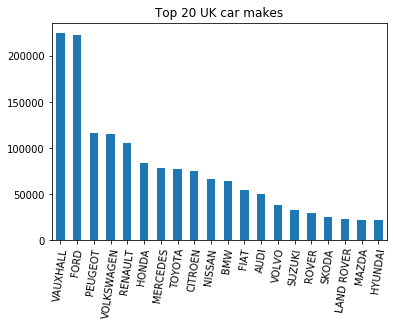

In [0]:
df_uk_vehicles['Vehicle_Make'].value_counts().head(20).plot(kind='bar', title = 'Top 20 UK car makes', rot=82)

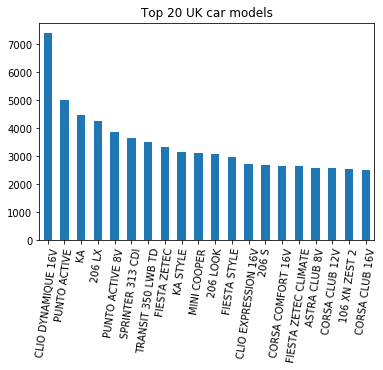

In [0]:
df_uk_vehicles['Vehicle_Model'].value_counts().head(20).plot(kind='bar', title = 'Top 20 UK car models', rot=82)

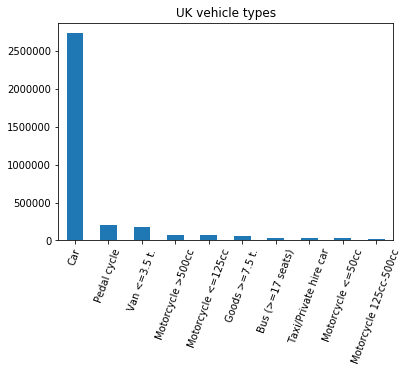

In [0]:
df_uk_vehicles['Vehicle_Type'].value_counts().head(10).plot(kind='bar', title = 'UK vehicle types', rot=70)

In [0]:
df_uk_accidents['Number_of_Casualties'].value_counts().head(7).plot(kind='bar', title = 'Number of UK casualties frequency')

In [0]:
df_uk_accidents.describe()[['Number_of_Casualties', 'Number_of_Vehicles']]

In [0]:
df_uk_vehicles['Sex_of_Driver'].value_counts().plot(kind='bar', title = 'Sex of UK Drivers')

In [0]:
df_uk_vehicles['Age_Band_of_Driver'].value_counts().plot(kind='bar', title = 'Age of UK Drivers')

In [0]:
df_uk_casualties['Casualty_Severity'].value_counts().plot(kind='bar', title = 'Severity of UK casualty')

In [0]:
df_uk_casualties['Casualty_Class'].value_counts().plot(kind='bar', title = 'Class of UK casualty')

In [0]:
df_uk_vehicles.describe()[['Age_of_Vehicle', 'Engine_Capacity_(CC)']]

In [0]:
df_uk_accidents['Weather_Conditions'].value_counts().plot(kind='bar', title = 'Weather conditions of UK accidents')

### Displaying data

In [0]:
cur_car_rating.head()

In [0]:
df_vehicles.head()

,TSTNO,VEHNO,MAKE,MAKED,MODEL,MODELD,YEAR,NHTSANO,BODY,BODYD,VIN,ENGINE,ENGINED,ENGDSP,TRANSM,TRANSMD,VEHTWT,CURBWT,WHLBAS,VEHLEN,VEHWID,VEHCG,STRSEP,STRSEPD,COLMEC,COLMECD,MODIND,MODINDD,MODDSC,BX1,BX2,BX3,BX4,BX5,BX6,BX7,BX8,BX9,BX10,BX11,BX12,BX13,BX14,BX15,BX16,BX17,BX18,BX19,BX20,BX21,VEHSPD,CRBANG,PDOF,BMPENG,BMPENGD,SILENG,SILENGD,APLENG,APLENGD,DPD1,DPD2,DPD3,DPD4,DPD5,DPD6,VDI,LENCNT,DAMDST,CRHDST,AX1,AX2,AX3,AX4,AX5,AX6,AX7,AX8,AX9,AX10,AX11,AX12,AX13,AX14,AX15,AX16,AX17,AX18,AX19,AX20,AX21,CARANG,VEHOR,VEHCOM
0,1,1,1,CHEVROLET,23,CITATION,1980.0,NaN,5H,FIVE DOOR HATCHBACK,*1X687AT106262,OTHR,OTHER,2.8,AF,AUTOMATIC - FRONT WHEEL DRIVE,1415.0,NaN,2664.0,4488.0,1730.0,1069.0,UN,NaN,OTH,NaN,P,PRODUCTION VEHICLE,"212-P,219-F,301-P CRDIST=10.8",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.2,0.0,0.0,NaN,NOT APPLICABLE,NaN,NOT APPLICABLE,NaN,NOT APPLICABLE,716.0,716.0,0.0,0.0,0.0,0.0,12FDEW3,NaN,NaN,709.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NO COMMENTS
1,2,1,1,CHEVROLET,6,IMPALA,1978.0,NaN,4S,FOUR DOOR SEDAN,NaN,V8IF,V8 INLINE FRONT,5.0,AR,AUTOMATIC - REAR WHEEL DRIVE,1783.0,NaN,2946.0,5387.0,1930.0,1275.0,NaN,NOT APPLICABLE,NON,NONE,P,PRODUCTION VEHICLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.1,0.0,330.0,NaN,NOT APPLICABLE,NaN,NOT APPLICABLE,NaN,NOT APPLICABLE,0.0,102.0,140.0,203.0,0.0,0.0,11FLME1,914.0,2184.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NO COMMENTS
2,2,2,5,PLYMOUTH,14,VOLARE,1976.0,NaN,4S,FOUR DOOR SEDAN,NaN,S6IF,STRAIGHT 6 INLINE FRONT,3.7,AR,AUTOMATIC - REAR WHEEL DRIVE,1737.0,NaN,2858.0,5110.0,1862.0,1240.0,UN,UNKNOWN,OTH,OTHER,M,MODIFIED VEHICLE,STRENGTHENED DOOR AND B-PILLAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,300.0,NaN,NOT APPLICABLE,NO,NO DIRECT ENGAGEMENT,NO,NO DIRECT ENGAGEMENT,76.0,178.0,241.0,279.0,330.0,152.0,10LPEW3,1524.0,533.0,343.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NO COMMENTS
3,3,1,1,CHEVROLET,6,IMPALA,1978.0,NaN,4S,FOUR DOOR SEDAN,NaN,OTHR,OTHER,5.0,AR,AUTOMATIC - REAR WHEEL DRIVE,1683.0,NaN,2946.0,5387.0,1930.0,1278.0,NaN,NOT APPLICABLE,NON,NONE,P,PRODUCTION VEHICLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.4,0.0,330.0,NaN,NOT APPLICABLE,NO,NO DIRECT ENGAGEMENT,NO,NO DIRECT ENGAGEMENT,0.0,102.0,140.0,203.0,0.0,0.0,11FLME1,914.0,2184.0,1024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NO COMMENTS
4,3,2,8,VOLKSWAGEN,9,RABBIT,1976.0,NaN,3H,THREE DOOR HATCHBACK,NaN,4CTF,4 CYLINDER TRANSVERSE FRONT,1.5,MF,MANUAL - FRONT WHEEL DRIVE,1061.0,NaN,2400.0,3945.0,1610.0,986.0,NaN,NOT APPLICABLE,NON,NONE,M,MODIFIED VEHICLE,"STIFFENED A-POST,B-POST,SILL,AND DOOR",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,300.0,NaN,NOT APPLICABLE,NO,NO DIRECT ENGAGEMENT,NO,NO DIRECT ENGAGEMENT,0.0,229.0,302.0,358.0,305.0,0.0,10LPEW3,1676.0,-251.0,358.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NO COMMENTS


In [0]:
df_tests.head()

In [0]:
df_uk_accidents.head()

In [0]:
df_uk_vehicles.head()

In [0]:
df_uk_casualties.head()

In [0]:
unique_uk_makes = df_uk_vehicles.Vehicle_Make.astype(str).unique()
unique_ncap_makes = df_vehicles[' MAKED'].astype(str).unique()
unique_uk_makes.sort()
unique_ncap_makes.sort()

In [0]:
for x in (unique_ncap_makes):
    print (x)

ACURA
AMERICAN
AUDI
BATTRONICS
BLUE BIRD
BMW
BRAUN
BUICK
CADILLAC
CARPENTER
CHAMPION
CHECKER
CHEVROLET
CHINOOK
CHRYSLER
CODA
COLLINS
COMUTA
DAEWOO
DAIHATSU
DELOREAN
DODGE
EAGLE
EEVC
EL DORADO
EU96/27/EC
EVA
FIAT
FORD
FREEDOM MOTORS
GEO
GMC
HOLDEN
HONDA
HUMMER
HYUNDAI
IH
IIHS
INFINITI
ISUZU
JAGUAR
JEEP
JET
KIA
LAND ROVER
LECTRA
LECTRIC
LEWIS
LEXUS
LINCOLN
MAZDA
MCI
MERCEDES
MERCURY
MG
MINI
MITSUBISHI
NHTSA
NISSAN
NOR-CAL
ODYSSEY
OLDSMOBILE
OTHER
PEUGEOT
PLYMOUTH
PONTIAC
PORSCHE
PREVOST
RAM
RENAISSANCE
RENAULT
ROLLX
SAAB
SATURN
SEBRING
SMART
SOLECTRIA
SUBARU
SUZUKI
TESLA
THOMAS
TIARA
TOYOTA
TRIUMPH
UM
VANTAGE
VOLKSWAGEN
VOLVO
WARD
WAYNE
WINNEBAGO
YUGO


In [0]:
for x in (unique_uk_makes):
    print (x)

ABARTH
AC (ELECTRIC)
ACCESS
ACURA
ADLY
AEBI
AEON
AGRIFAC
AIXAM
AJP
AJS
ALEXANDER DENNIS
ALFA ROMEO
ALL WHEEL DRIVE
APPLIED SWEEPER
APRILIA
ASIA
ASTON MARTIN
ATALA
AUDI
AUSTIN
AUSTIN HEALEY
AUSTIN MORRIS
AUTO-TRAIL
AUTOSAN
AVELING BARFORD
AVIA
AXR
BAJAJ
BAOTIAN
BARONI
BAROSSA
BASHAN
BCS
BEDFORD
BEELINE
BELARUS
BENELLI
BENFORD
BENTLEY
BETA
BETTER
BIMOTA
BITELLI
BMC
BMW
BOMAG
BOMBARDIER
BOND
BONSER
BOOM
BOVA
BRANSON
BRISTOL
BRISTOL (BLMC)
BRIT JEFFREY DIAMOND
BRITISH TRACKSTAR
BSA
BTM
BUELL
BUGATTI
BUICK
BULLIT
BULTACO
CADILLAC
CAETANO
CAGIVA
CAN-AM
CARBODIES
CASE
CASE IH
CASE INTERNATIONAL
CATERHAM
CATERPILLAR
CCM
CF MOTO
CH RACING
CHAMP
CHAUSSON
CHEVROLET
CHEVROLET GMC
CHITUMA
CHONGQING
CHRYSLER
CHUNLAN
CI MOTORHOME
CIMOTORHOME
CITROEN
CKR
CLAAS
CLASSIC CUSTOM
COMMER
COSSACK
COUNTY COMM CARS
CPI
CROMPTON (LEYLAND)
CSR
CTM
CZ
DACIA
DAELIM
DAEWOO
DAF
DAF TRUCKS
DAIFO
DAIHATSU
DAIMLER
DAJIANG
DAKAR
DATSUN
DAVID BROWN
DAYANG
DAYUN
DEMM
DENNIS
DENNIS FIRE
DERBI
DEUTZ FAHR
DFSK
DI BLASI
DI BL

In [0]:
_make = 'LAND ROVER'
print (len(df_uk_vehicles[df_uk_vehicles.Vehicle_Make == _make].Vehicle_Model))
display(df_uk_vehicles[df_uk_vehicles.Vehicle_Make == _make].Vehicle_Model)


22864


239204     RANGE ROVER EVOQUE PR-LUX SD4A
239212     RANGE ROVER EVOQUE PURE T SD4A
239455            DISCOVERY HSE SDV6 AUTO
239593     RANGE ROVER EVOQUE AUTOBI SD4A
239641          RANGE ROVER SP HSE TDV6 A
240007          RANGEROVER SPT TDV6 HSE A
240075          RANGE ROVER SP HSE TDV6 A
240248                        DISCOVERY 3
240280          RANGE ROVER SP HSE TDV6 A
240285          RANGE ROVER SP HSE TDV8 A
240492            DISCOVERY HSE SDV6 AUTO
240493              DEFENDER 90 XS SW SWB
240656     RROVER EVOQUE HSE DYN LUX TD4A
240698            FREELANDER KALAHARI H/B
240796              RANGEROVER V8 SC AUTO
240829          RANGE ROVER SP HSE TDV6 A
241160          RANGEROVER SPT TDV6 HSE A
241441     R ROVER SPORT HSE DYNAM SDV6 A
241532        RANGE ROVER VOGUE TDV6 AUTO
241641          RANGE ROVER SP HSE TDV6 A
241680           RANGEROVER V8 VOGUE SE A
241724     RANGE ROVER EVOQUE PRESTIGSD4A
241764       RANGE ROVER SPORT HSE SDV6 A
241999          RANGEROVER SPT V8S

In [0]:
df_vehicles_processed = df_uk_vehicles[df_uk_vehicles.Vehicle_Make.notnull() 
                              & df_uk_vehicles.Vehicle_Model.notnull()
                              & df_uk_vehicles.Vehicle_Year.notnull()]
df_vehicles_processed = df_vehicles_processed[(df_vehicles_processed.Vehicle_Year >= 1990) & (df_vehicles_processed.Vehicle_Type == 'Car')]
df_years_grouped = df_vehicles_processed.groupby('Vehicle_Year')

In [0]:
len(df_uk_vehicles[df_uk_vehicles.Vehicle_Make.notnull() 
                              & df_uk_vehicles.Vehicle_Model.notnull()
                              & df_uk_vehicles.Vehicle_Year.notnull()])

1382821

In [0]:
len(df_uk_ncap_match.Vehicle_Make.unique())

4

In [0]:
len(df_uk_ncap_match.Vehicle_Model.unique())
df_x = df_uk_ncap_match.drop_duplicates(subset=['Vehicle_Model', 'Vehicle_Year'])
len(df_x)

41

In [0]:
print(len(df_uk_vehicles))
print(len(df_uk_ncap_match))

3753696
1371


In [0]:
df_uk_vehicles[df_uk_vehicles.Accident_Index == '200506L030680'][['Vehicle_Make', 'Vehicle_Model']]

,Vehicle_Make,Vehicle_Model
830271,SUZUKI,SWIFT GLX AUTO
830272,NaN,NaN


In [0]:
df_x = df_uk_ncap_match.drop_duplicates(subset=['Vehicle_Model'])
display(df_x[['Accident_Index', 'Vehicle_Make', 'Vehicle_Model']])

,Accident_Index,Vehicle_Make,Vehicle_Model
968823,200540B016730,AUDI,100
3683466,2014450015038,BMW,325I
2176654,200906M011657,HONDA,PRELUDE
934560,20053102B2756,ISUZU,TROOPER
761288,200501JC30753,NISSAN,MAXIMA
1024727,2005460018087,SUBARU,LEGACY
2297124,20094100K0237,TOYOTA,CELICA
917284,200522DD44914,TOYOTA,COROLLA
1093459,200591NH02232,VOLKSWAGEN,PASSAT
2243990,2009219007373,FORD,ESCORT


In [0]:
car_accident_indicies = df_uk_vehicles[(df_uk_vehicles.Vehicle_Type == 'Car') | (df_uk_vehicles.Vehicle_Type == 'Van <=3.5 t.')].Accident_Index.unique()

In [0]:
print(len(car_accident_indicies))
print(len(df_uk_accidents))
print(len(df_vehicles_processed))
df_uk_ncap_match.to_csv('matched_vans.csv')

1838320
1907200
77960
